In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import yfinance as yf

In [ ]:
class Time2Vec:
    def __init__(self, kernel_size=1):
        self.k = kernel_size

    def __call__(self, inputs):
        wb = tf.Variable(tf.random.normal([inputs.shape[-1], self.k]))
        bb = tf.Variable(tf.random.normal([self.k]))
        wa = tf.Variable(tf.random.normal([inputs.shape[-1], self.k]))
        ba = tf.Variable(tf.random.normal([self.k]))

        bias = tf.matmul(inputs, wb) + bb
        dp = tf.matmul(inputs, wa) + ba
        wgts = tf.math.sin(bias) + dp

        return tf.concat([inputs, wgts], axis=-1)

In [ ]:
data = pd.read_csv('TCS.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

In [ ]:
period= 5


In [ ]:
# roc
data['roc'] = ((data['Close'] - data['Close'].shift(period)) / data['Close'].shift(period)) * 100

In [ ]:
# rsi
data['change_wrt_prevday'] = data['Close']- data['Close'].shift(1)

data['gain']=np.where(data['change_wrt_prevday'] >= 0,data['change_wrt_prevday'], 0)
data['loss']=np.where(data['change_wrt_prevday'] < 0,-data['change_wrt_prevday'], 0)

data['avg_gain'] = data['gain'].rolling(window=period).mean()
data['avg_loss'] = data['loss'].rolling(window=period).mean()

data['rsi'] = 100 - (100 / (1 + (data['avg_gain'] / data['avg_loss'])))

In [ ]:
# Bollinger bands

data['SMA'] = data['Close'].rolling(window=period).mean()
data['SD'] = data['Close'].rolling(window=period).std()

data['UB'] = data['SMA'] + 2* data['SD']
data['LB'] = data['SMA'] - 2* data['SD']
data['bb'] = data['UB']-data['LB']
# data['Signal'] = 0
# data.loc[data['Close'] <= data['LB'], 'Signal'] = 1
# data.loc[data['Close'] >= data['UB'], 'Signal'] = -1

In [ ]:
data = data.dropna(subset=['rsi'])

In [ ]:
data = data.fillna(0)

In [ ]:
data=data.reset_index(drop=True)

In [ ]:
data['index'] = range(len(data))

features = ['Open', 'High', 'Low', 'Volume', 'Adj Close', 'Close', 'roc', 'rsi', 'bb', 'index']
target = 'Close'

In [ ]:
data.head()

,Date,Open,High,Low,Volume,Close,Adj Close,roc,change_wrt_prevday,gain,loss,avg_gain,avg_loss,rsi,SMA,SD,UB,LB,bb,index
0,1962-01-08,0.0,1.373047,1.328125,1523200,1.343750,0.240706,0.000000,-0.037109,0.000000,0.037109,0.000000,0.017188,0.000000,1.391797,0.033019,1.457835,1.325759,0.132076,0
1,1962-01-09,0.0,1.363281,1.335938,499200,1.341797,0.240356,-6.147564,-0.001953,0.000000,0.001953,0.000000,0.017578,0.000000,1.374219,0.031146,1.436511,1.311926,0.124585,1
2,1962-01-10,0.0,1.355469,1.333984,300800,1.345703,0.241056,-4.834295,0.003906,0.003906,0.000000,0.000781,0.014453,5.127884,1.360547,0.023299,1.407144,1.313949,0.093195,2
3,1962-01-11,0.0,1.355469,1.343750,371200,1.343750,0.240706,-3.370787,-0.001953,0.000000,0.001953,0.000781,0.010156,7.142483,1.351172,0.016653,1.384478,1.317866,0.066612,3
4,1962-01-12,0.0,1.363281,1.343750,390400,1.351563,0.242106,-2.121581,0.007813,0.007813,0.000000,0.002344,0.008203,22.222825,1.345313,0.003757,1.352827,1.337798,0.015028,4


In [ ]:
data = data.dropna()
data = data.reset_index(drop=True)

In [ ]:
sequence_length = 100

In [ ]:
data['Index'] = np.arange(len(data))

In [ ]:
time_data = data['Index'].values.reshape(-1, 1).astype(float)
time_tensor = tf.convert_to_tensor(time_data, dtype=tf.float32)

In [ ]:
time2vec_layer = Time2Vec(kernel_size=4)
time2vec_output = time2vec_layer(time_tensor)


In [ ]:
time2vec_df = pd.DataFrame(time2vec_output.numpy(), columns=[f'Time2Vec{i}' for i in range(time2vec_output.shape[1])])

In [ ]:
  final_data = pd.concat([data, time2vec_df], axis=1)

In [ ]:
final_data.head()

,Date,Open,High,Low,Volume,Close,Adj Close,roc,change_wrt_prevday,gain,...,UB,LB,bb,index,Index,Time2Vec0,Time2Vec1,Time2Vec2,Time2Vec3,Time2Vec4
0,1962-01-08,0.0,1.373047,1.328125,1523200,1.343750,0.240706,0.000000,-0.037109,0.000000,...,1.457835,1.325759,0.132076,0,0,0.0,-0.602429,-0.379905,0.490647,1.103595
1,1962-01-09,0.0,1.363281,1.335938,499200,1.341797,0.240356,-6.147564,-0.001953,0.000000,...,1.436511,1.311926,0.124585,1,1,1.0,-1.834308,1.480514,0.598912,1.479900
2,1962-01-10,0.0,1.355469,1.333984,300800,1.345703,0.241056,-4.834295,0.003906,0.003906,...,1.407144,1.313949,0.093195,2,2,2.0,-3.529578,4.672602,0.186809,1.856918
3,1962-01-11,0.0,1.355469,1.343750,371200,1.343750,0.240706,-3.370787,-0.001953,0.000000,...,1.384478,1.317866,0.066612,3,3,3.0,-6.047489,8.266840,2.413891,2.234627
4,1962-01-12,0.0,1.363281,1.343750,390400,1.351563,0.242106,-2.121581,0.007813,0.007813,...,1.352827,1.337798,0.015028,4,4,4.0,-9.070222,10.797872,3.402214,2.613010


In [ ]:
features = ['Open', 'High', 'Low', 'Volume', 'Adj Close', 'Close', 'roc', 'rsi', 'bb', 'index','Time2Vec0','Time2Vec1','Time2Vec2','Time2Vec3','Time2Vec4']

In [ ]:
X = []
y = []

for i in range(len(final_data) - sequence_length):
    X.append(final_data[features].iloc[i:i+sequence_length].values)
    y.append(final_data[target].iloc[i+sequence_length])

In [ ]:
X = np.array(X)
y = np.array(y).reshape(-1, 1)

In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y)

In [ ]:
split = 0.95
X_train, X_test = X_scaled[:int(split*len(X))], X_scaled[int(split*len(X)):]
y_train, y_test = y_scaled[:int(split*len(y))], y_scaled[int(split*len(y)):]

In [ ]:

model=Sequential()
model.add(LSTM(128,return_sequences=False,input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_split=0.2, verbose=1)

Epoch 1/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0865 - val_loss: 0.0191
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0066 - val_loss: 0.0125
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - val_loss: 0.0116
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - val_loss: 0.0138
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - val_loss: 0.0165
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - val_loss: 0.0221
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - val_loss: 0.0180
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - val_loss: 0.0220
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 0.0301
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 0.0365
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 0.0321
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss:

In [ ]:
y_test_pred_scaled = model.predict(X_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_scaled)

490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


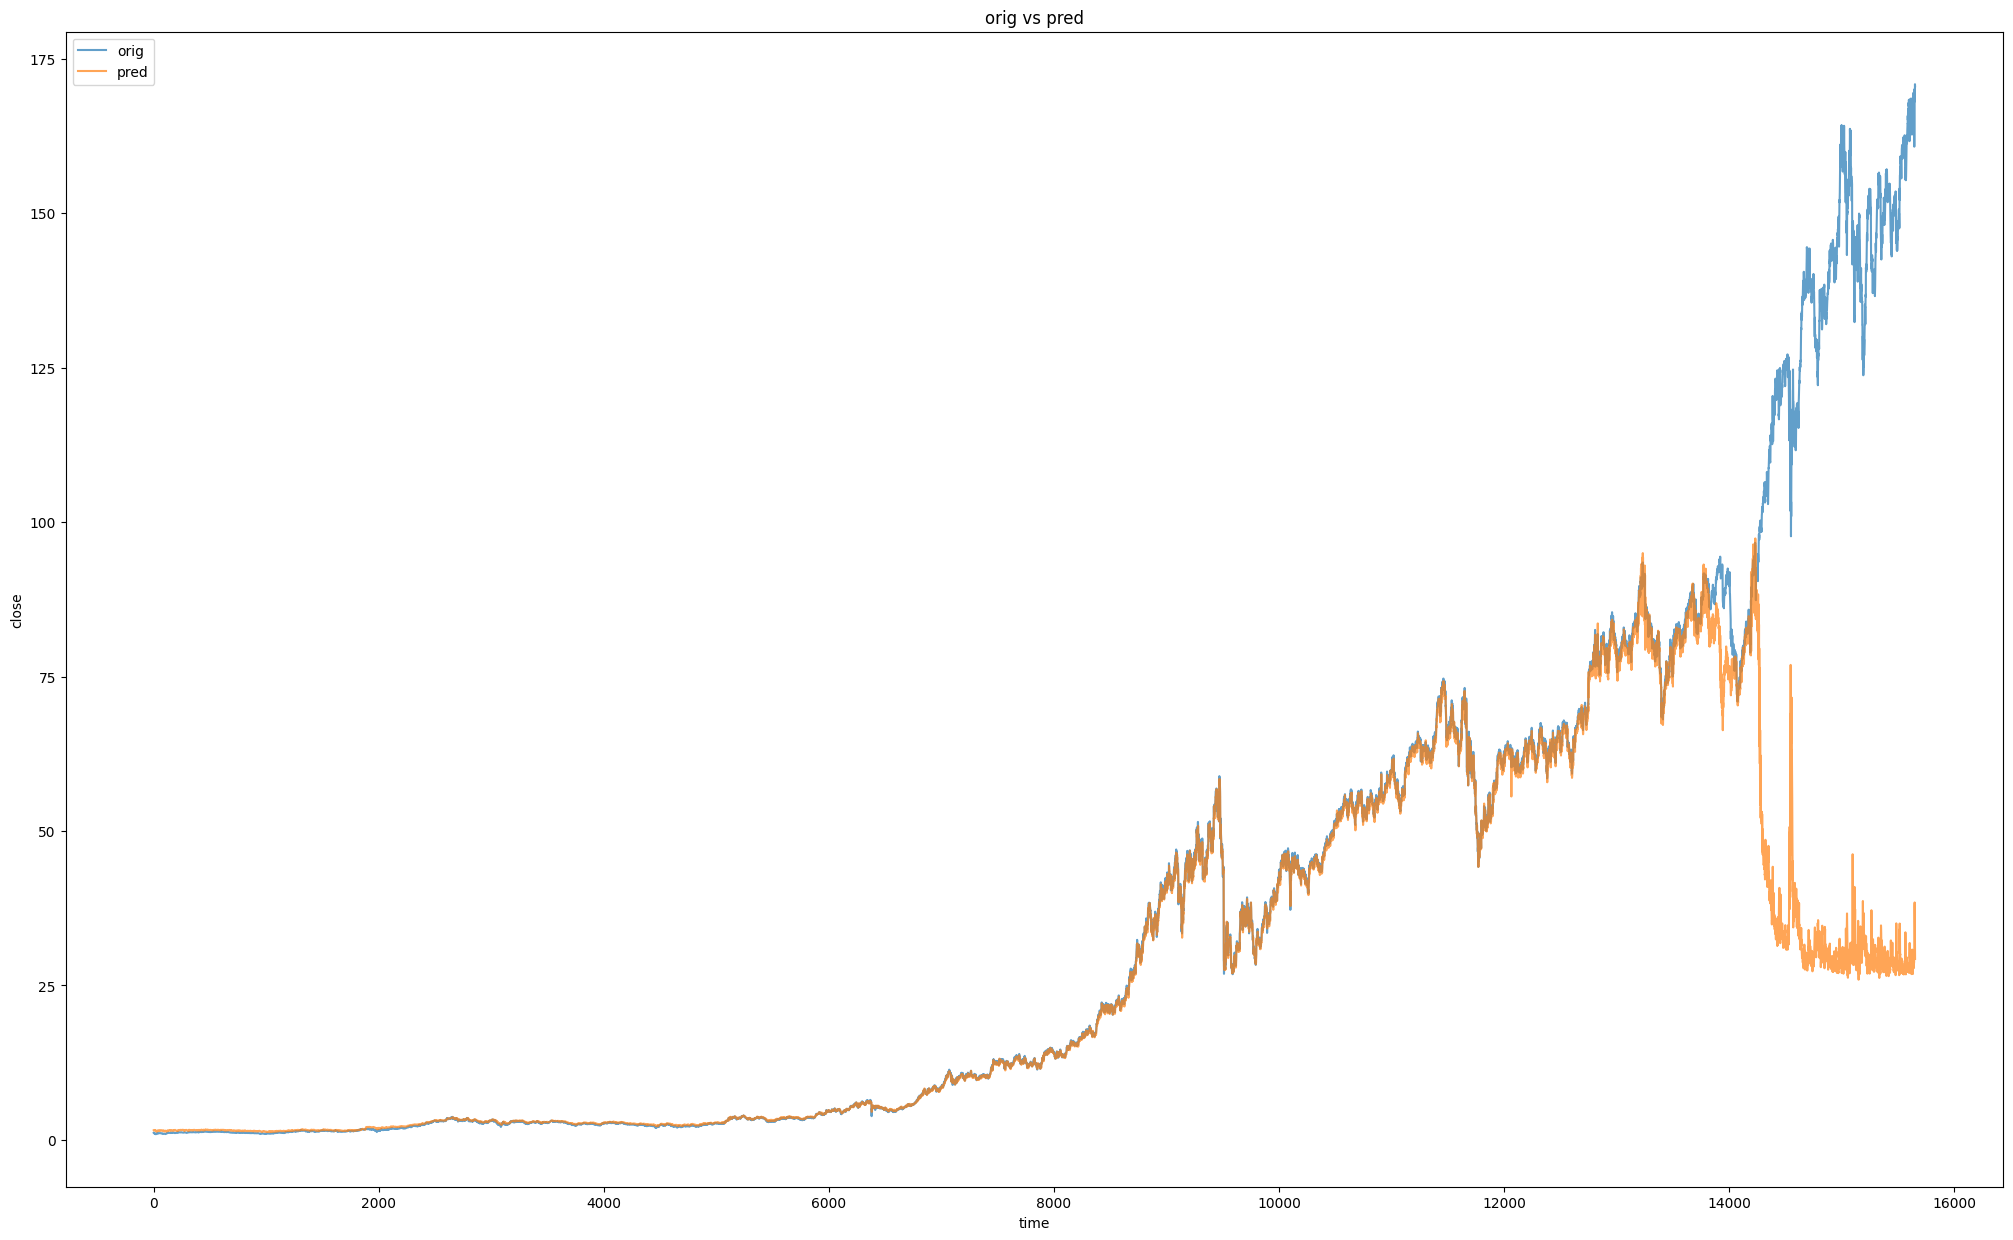

In [ ]:
plt.figure(figsize=(25, 15))
plt.plot(y_test_actual, label='orig', alpha=0.7)
plt.plot(y_test_pred, label='pred', alpha=0.7)
plt.title('orig vs pred')
plt.xlabel('time')
plt.ylabel('close')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2 = r2_score(y_test_actual, y_test_pred)
print(r2)

0.427546549790748


In [ ]:
y_test_pred_scaled = model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


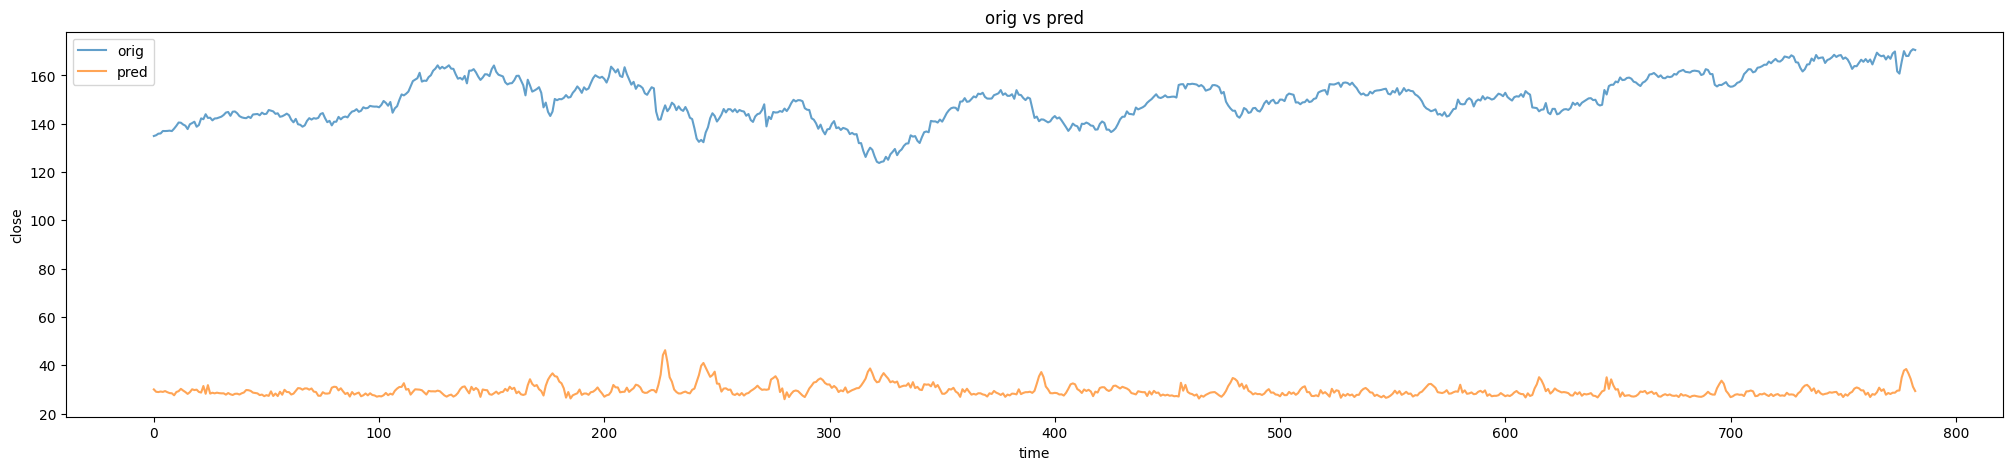

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(y_test_actual, label='orig', alpha=0.7)
plt.plot(y_test_pred, label='pred', alpha=0.7)
plt.title('orig vs pred')
plt.xlabel('time')
plt.ylabel('close')
plt.legend()
plt.show()

In [ ]:
r2 = r2_score(y_test_actual, y_test_pred)
print(r2)

-168.33337863480799
